In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

warnings.filterwarnings('ignore')
print("All libraries imported successfully.")

2025-11-01 18:41:57.489653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/reshma/Documents/Coding/capstone_project/attack/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/reshma/Documents/Coding/capstone_project/attack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/reshma/Documents/Coding/capstone_project/attack/lib/python3.9/site-packages/art/estimators/cert

All libraries imported successfully.


In [ ]:
DATA_PATH = 'CIC-Darknet2020.csv'
TARGET_LABELS = ['Tor', 'Non-Tor', 'VPN', 'NonVPN']

MODEL_PATH = 'model-multi.h5'
SCALER_PATH = 'scaler-multi.pkl'
DEFENSE_MODEL_PREFIX = 'defense_models/combined_defense'

AUTOENCODER_CONFIG = {
    'encoding_dims': [64, 32, 16],
    'noise_factor': 0.1,
    'activation': 'relu',
    'dropout_rate': 0.2
}

SQUEEZING_CONFIG = {
    'bit_depth': 8,
    'spatial_smoothing': False,
    'median_filter_size': 3
}

FGSM_EPS = 0.1
PGD_EPS = 0.1
PGD_EPS_STEP = 0.01
PGD_MAX_ITER = 40
ATTACK_BATCH_SIZE = 64

AUTOENCODER_EPOCHS = 50
AUTOENCODER_BATCH_SIZE = 128

print("Configuration set successfully.")


Configuration set successfully.


In [ ]:
def load_and_preprocess_data():
    """Load and preprocess CIC-Darknet2020 dataset"""
    print("Loading dataset...")
    try:
        df = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        print(f"Error: '{DATA_PATH}' not found.")
        return None
    
    df.columns = [*df.columns[:-2], 'Label', 'Label_Type']
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df_multi = df[df['Label'].isin(TARGET_LABELS)].copy()
    
    print(f"Dataset loaded: {df_multi.shape[0]} samples")
    
    non_feature_cols = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 
                       'Protocol', 'Timestamp', 'Label', 'Label_Type']
    X = df_multi.drop(columns=non_feature_cols).apply(pd.to_numeric)
    y = df_multi['Label']
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    n_classes = len(le.classes_)
    target_names = le.classes_
    y_ohe = to_categorical(y_encoded, num_classes=n_classes)
    
    print("\n--- Class Encoding Mapping ---")
    for index, label in enumerate(le.classes_):
        print(f"Class Index {index} -> {label}")
    
    # Train/Test Split
    X_train, X_test, y_train_ohe, y_test_ohe, y_train_encoded, y_test_encoded = train_test_split(
        X, y_ohe, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )
    
    X_train, X_val, y_train_ohe, y_val_ohe, y_train_encoded, y_val_encoded = train_test_split(
        X_train, y_train_ohe, y_train_encoded,
        test_size=0.1,
        random_state=42,
        stratify=y_train_encoded
    )
    
    try:
        scaler = joblib.load(SCALER_PATH)
        print(f"\nScaler '{SCALER_PATH}' loaded successfully.")
    except FileNotFoundError:
        print(f"\nScaler not found. Creating new scaler...")
        scaler = StandardScaler()
        scaler.fit(X_train)
        joblib.dump(scaler, SCALER_PATH)
        print(f"Scaler saved to '{SCALER_PATH}'")
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for CNN
    n_features = X_test_scaled.shape[1]
    X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], n_features, 1))
    X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], n_features, 1))
    X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], n_features, 1))
    
    print(f"\nData preparation complete:")
    print(f"  Training samples: {len(X_train_cnn)}")
    print(f"  Validation samples: {len(X_val_cnn)}")
    print(f"  Test samples: {len(X_test_cnn)}")
    print(f"  Features: {n_features}")
    print(f"  Classes: {n_classes}")
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'X_train_cnn': X_train_cnn,
        'X_val_cnn': X_val_cnn,
        'X_test_cnn': X_test_cnn,
        'y_train_ohe': y_train_ohe,
        'y_val_ohe': y_val_ohe,
        'y_test_ohe': y_test_ohe,
        'y_train_encoded': y_train_encoded,
        'y_val_encoded': y_val_encoded,
        'y_test_encoded': y_test_encoded,
        'target_names': target_names,
        'n_features': n_features,
        'n_classes': n_classes,
        'scaler': scaler
    }

data = load_and_preprocess_data()

Loading dataset...
Dataset loaded: 158566 samples

--- Class Encoding Mapping ---
Class Index 0 -> Non-Tor
Class Index 1 -> NonVPN
Class Index 2 -> Tor
Class Index 3 -> VPN

Scaler 'scaler-multi.pkl' loaded successfully.

Data preparation complete:
  Training samples: 114166
  Validation samples: 12686
  Test samples: 31714
  Features: 76
  Classes: 4


In [ ]:
class FeatureSqueezingLayer:    
    def __init__(self, bit_depth=8, spatial_smoothing=False, median_filter_size=3):
        self.bit_depth = bit_depth
        self.spatial_smoothing = spatial_smoothing
        self.median_filter_size = median_filter_size
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def bit_depth_reduction(self, X):
        X_scaled = self.scaler.fit_transform(X)
        max_val = 2 ** self.bit_depth - 1
        X_quantized = np.round(X_scaled * max_val) / max_val
        return X_quantized
    
    def median_smoothing(self, X, window_size=3):
        X_smoothed = np.copy(X)
        for i in range(X.shape[1]):
            for j in range(len(X)):
                start = max(0, j - window_size // 2)
                end = min(len(X), j + window_size // 2 + 1)
                X_smoothed[j, i] = np.median(X[start:end, i])
        return X_smoothed
    
    def quantization(self, X, num_bins=256):
        X_scaled = self.scaler.fit_transform(X)
        X_quantized = np.floor(X_scaled * (num_bins - 1)) / (num_bins - 1)
        return X_quantized
    
    def apply_squeezing(self, X, methods=['bit_depth', 'quantization']):
        X_squeezed = X.copy()
        
        if 'bit_depth' in methods:
            X_squeezed = self.bit_depth_reduction(X_squeezed)
            
        if 'quantization' in methods:
            X_squeezed = self.quantization(X_squeezed)
            
        if 'median' in methods:
            X_squeezed = self.median_smoothing(X_squeezed)
        
        return X_squeezed

print("Feature Squeezing Layer defined.")

Feature Squeezing Layer defined.


In [ ]:
class DenoisingAutoencoder:    
    def __init__(self, input_dim, encoding_dims=[64, 32, 16], 
                 noise_factor=0.1, activation='relu', dropout_rate=0.2):
        self.input_dim = input_dim
        self.encoding_dims = encoding_dims
        self.noise_factor = noise_factor
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.autoencoder = None
        self.encoder = None
        self.history = None
        
    def add_noise(self, X):
        noise = np.random.normal(loc=0.0, scale=self.noise_factor, size=X.shape)
        X_noisy = X + noise
        return np.clip(X_noisy, 0., 1.)
    
    def build_autoencoder(self):
        input_layer = layers.Input(shape=(self.input_dim,))
        
        encoded = input_layer
        for dim in self.encoding_dims:
            encoded = layers.Dense(dim, activation=self.activation)(encoded)
            encoded = layers.BatchNormalization()(encoded)
            encoded = layers.Dropout(self.dropout_rate)(encoded)
        
        bottleneck_dim = self.encoding_dims[-1]
        bottleneck = layers.Dense(bottleneck_dim // 2, activation=self.activation, 
                                  name='bottleneck')(encoded)
        
        decoded = bottleneck
        for dim in reversed(self.encoding_dims[:-1]):
            decoded = layers.Dense(dim, activation=self.activation)(decoded)
            decoded = layers.BatchNormalization()(decoded)
            decoded = layers.Dropout(self.dropout_rate)(decoded)

        output_layer = layers.Dense(self.input_dim, activation='sigmoid')(decoded)
        
        self.autoencoder = models.Model(input_layer, output_layer)
        self.encoder = models.Model(input_layer, bottleneck)
        
        self.autoencoder.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        print("Autoencoder architecture built:")
        self.autoencoder.summary()
        
        return self.autoencoder
    
    def train(self, X_train, X_val, epochs=50, batch_size=128, verbose=1):
        X_train_noisy = self.add_noise(X_train)
        X_val_noisy = self.add_noise(X_val)
    
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]

        self.history = self.autoencoder.fit(
            X_train_noisy, X_train,
            validation_data=(X_val_noisy, X_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return self.history
    
    def purify(self, X):
        return self.autoencoder.predict(X, verbose=0)
    
    def save_model(self, filepath):
        self.autoencoder.save(filepath)
        print(f"Autoencoder saved to {filepath}")
    
    def load_model(self, filepath):
        self.autoencoder = keras.models.load_model(filepath)
        bottleneck_layer = self.autoencoder.get_layer('bottleneck')
        self.encoder = models.Model(self.autoencoder.input, bottleneck_layer.output)
        print(f"Autoencoder loaded from {filepath}")

print("Denoising Autoencoder class defined.")

Denoising Autoencoder class defined.


In [ ]:
class CombinedDefense:    
    def __init__(self, input_dim, autoencoder_config=None, squeezing_config=None):
        self.input_dim = input_dim
        
        if autoencoder_config is None:
            autoencoder_config = AUTOENCODER_CONFIG
        
        if squeezing_config is None:
            squeezing_config = SQUEEZING_CONFIG
        
        self.autoencoder = DenoisingAutoencoder(input_dim, **autoencoder_config)
        self.feature_squeezer = FeatureSqueezingLayer(**squeezing_config)
        self.autoencoder.build_autoencoder()
        
    def train_defense(self, X_train, X_val, epochs=50, batch_size=128):
        print("\n" + "="*70)
        print("TRAINING DEFENSE SYSTEM")
        print("="*70)
        history = self.autoencoder.train(X_train, X_val, epochs, batch_size)
        print("✓ Defense training complete!")
        return history
    
    def defend(self, X, squeezing_methods=['bit_depth', 'quantization'], 
               apply_autoencoder=True, apply_squeezing=True):
        X_defended = X.copy()
        
        if apply_squeezing:
            X_defended = self.feature_squeezer.apply_squeezing(
                X_defended, methods=squeezing_methods
            )
        
        if apply_autoencoder:
            X_defended = self.autoencoder.purify(X_defended)
        
        return X_defended
    
    def save_models(self, filepath_prefix):
        self.autoencoder.save_model(f"{filepath_prefix}_autoencoder.h5")
        print(f"Models saved with prefix: {filepath_prefix}")
    
    def load_models(self, filepath_prefix):
        self.autoencoder.load_model(f"{filepath_prefix}_autoencoder.h5")
        print(f"Models loaded from prefix: {filepath_prefix}")

print("Combined Defense System class defined.")

Combined Defense System class defined.


In [ ]:
if data is not None:
    defense = CombinedDefense(
        input_dim=data['n_features'],
        autoencoder_config=AUTOENCODER_CONFIG,
        squeezing_config=SQUEEZING_CONFIG
    )
    
    # Train defense system
    defense_history = defense.train_defense(
        data['X_train'], 
        data['X_val'],
        epochs=AUTOENCODER_EPOCHS,
        batch_size=AUTOENCODER_BATCH_SIZE
    )
    
    import os
    os.makedirs('defense_models', exist_ok=True)
    defense.save_models(DEFENSE_MODEL_PREFIX)
    
    print("\n✓ Defense system ready!")
else:
    print("Data not loaded. Cannot train defense system.")


Autoencoder architecture built:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 76)             │         4,940 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,844 (61.89 KB)

 Trainable params: 15,428 (60.27 KB)

 Non-trainable params: 416 (1.62 KB)


TRAINING DEFENSE SYSTEM
Epoch 1/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.7822 - mae: 0.5204 - val_loss: 0.7383 - val_mae: 0.3245 - learning_rate: 0.0010
Epoch 2/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6006 - mae: 0.3306 - val_loss: 0.7244 - val_mae: 0.3125 - learning_rate: 0.0010
Epoch 3/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5287 - mae: 0.3166 - val_loss: 0.7201 - val_mae: 0.3083 - learning_rate: 0.0010
Epoch 4/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5924 - mae: 0.3139 - val_loss: 0.7176 - val_mae: 0.3068 - learning_rate: 0.0010
Epoch 5/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5968 - mae: 0.3115 - val_loss: 0.7166 - val_mae: 0.3059 - learning_rate: 0.0010
Epoch 6/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6303 - mae: 0.3099 - val_loss: 0.7147 - val_mae: 0.3050 - learning_rate: 0.0010
Epoch 7/50
892/892 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5887 - mae: 0.3085 - val_loss: 0.7132 - val_mae: 0.3041 - le

✓ Defense training complete!
Autoencoder saved to defense_models/combined_defense_autoencoder.h5
Models saved with prefix: defense_models/combined_defense

✓ Defense system ready!


In [ ]:
def get_art_classifier(model_path, n_features, n_classes):
    try:
        model = load_model(model_path)
        print(f"Model '{model_path}' loaded successfully.")
    except Exception as e:
        print(f"Error: Model file '{model_path}' not found or failed to load.")
        print(f"Details: {e}")
        return None, None
    
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    
    classifier = TensorFlowV2Classifier(
        model=model,
        loss_object=loss_object,
        input_shape=(n_features, 1),
        nb_classes=n_classes,
        channels_first=False
    )
    
    return model, classifier

if data is not None:
    model, art_classifier = get_art_classifier(
        MODEL_PATH, 
        data['n_features'], 
        data['n_classes']
    )
    
    X_test_art = data['X_test_cnn'].astype(np.float32)
    
    print("\n✓ Classifier loaded and ART wrapper created!")
else:
    print("Data not loaded. Cannot load classifier.")

Model 'model-multi.h5' loaded successfully.

✓ Classifier loaded and ART wrapper created!


In [11]:
def evaluate_model(y_true_encoded, y_pred_probs, scenario_name, target_names):
    """Evaluate model performance"""
    y_pred_encoded = np.argmax(y_pred_probs, axis=1)
    acc = accuracy_score(y_true_encoded, y_pred_encoded)
    
    print(f"\n{'='*70}")
    print(f"{scenario_name.upper()}")
    print(f"{'='*70}")
    print(f"Accuracy: {acc * 100:.4f}%")
    
    print("\nClassification Report:")
    print(classification_report(y_true_encoded, y_pred_encoded, 
                               target_names=target_names, zero_division=0))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true_encoded, y_pred_encoded)
    print(cm)
    
    return acc, cm

def plot_confusion_matrix(cm, target_names, title, save_path=None):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=target_names, yticklabels=target_names)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("Evaluation helper functions defined.")

Evaluation helper functions defined.



Evaluating baseline (clean) model performance...

BASELINE (CLEAN DATA)
Accuracy: 95.3585%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       1.00      0.99      0.99     22079
      NonVPN       0.86      0.85      0.85      4772
         Tor       0.82      0.87      0.85       279
         VPN       0.86      0.88      0.87      4584

    accuracy                           0.95     31714
   macro avg       0.88      0.90      0.89     31714
weighted avg       0.95      0.95      0.95     31714


Confusion Matrix:
[[21885   137     1    56]
 [   43  4073    48   608]
 [    0    27   244     8]
 [   19   520     5  4040]]


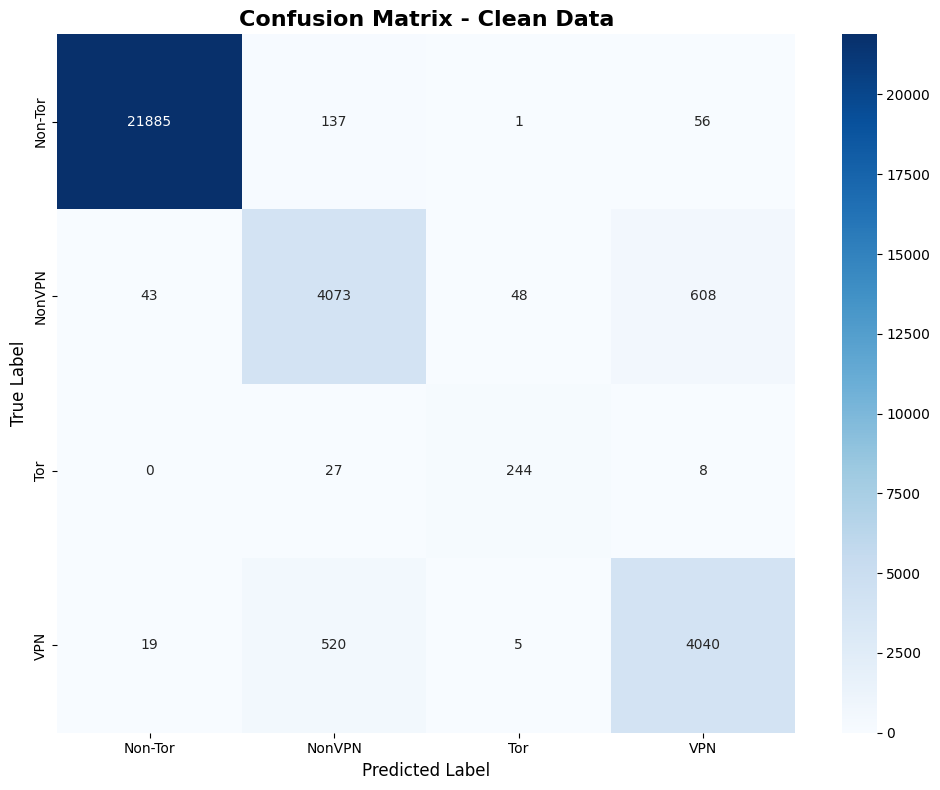

In [12]:
if 'model' in locals() and data is not None:
    print("\nEvaluating baseline (clean) model performance...")
    y_pred_clean_probs = model.predict(X_test_art, verbose=0)
    
    clean_acc, clean_cm = evaluate_model(
        data['y_test_encoded'], 
        y_pred_clean_probs,
        "Baseline (Clean Data)",
        data['target_names']
    )
    
    plot_confusion_matrix(
        clean_cm, 
        data['target_names'],
        'Confusion Matrix - Clean Data',
        save_path='cm_clean.png'
    )
else:
    print("Model or data not loaded. Skipping baseline evaluation.")



GENERATING FGSM ATTACK (Epsilon = 0.1)

Generating adversarial examples...
✓ FGSM attack generated in 27.22s

FGSM ATTACK (EPS=0.1) - NO DEFENSE
Accuracy: 23.6993%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.78      0.09      0.15     22079
      NonVPN       0.13      0.55      0.21      4772
         Tor       0.55      0.83      0.66       279
         VPN       0.34      0.61      0.43      4584

    accuracy                           0.24     31714
   macro avg       0.45      0.52      0.36     31714
weighted avg       0.61      0.24      0.21     31714


Confusion Matrix:
[[ 1891 16311    34  3843]
 [  365  2610   141  1656]
 [    1    33   231    14]
 [  177  1606    17  2784]]

Accuracy Drop: 71.6592%


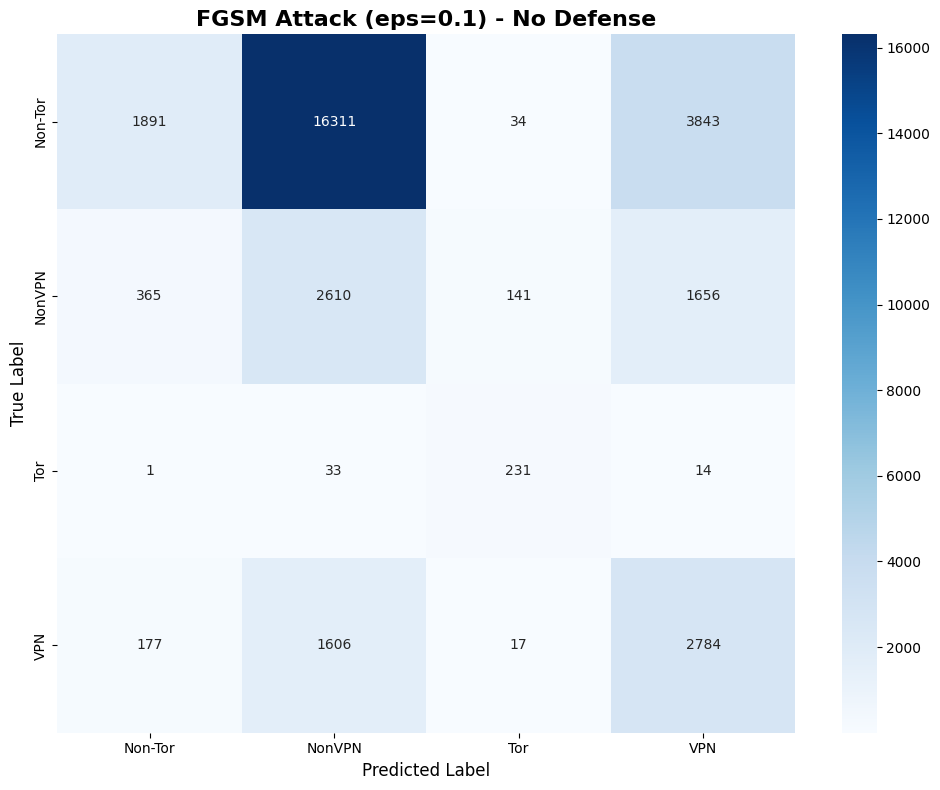

In [ ]:
if 'art_classifier' in locals() and data is not None:
    print("\n" + "="*70)
    print(f"GENERATING FGSM ATTACK (Epsilon = {FGSM_EPS})")
    print("="*70)
    
    fgsm_attack = FastGradientMethod(
        art_classifier,
        eps=FGSM_EPS,
        batch_size=ATTACK_BATCH_SIZE
    )
    
    print("\nGenerating adversarial examples...")
    start_time = time.time()
    X_fgsm = fgsm_attack.generate(x=X_test_art, y=data['y_test_ohe'])
    fgsm_time = time.time() - start_time
    
    print(f"✓ FGSM attack generated in {fgsm_time:.2f}s")
    
    y_pred_fgsm_probs = model.predict(X_fgsm, verbose=0)
    fgsm_acc, fgsm_cm = evaluate_model(
        data['y_test_encoded'],
        y_pred_fgsm_probs,
        f"FGSM Attack (eps={FGSM_EPS}) - No Defense",
        data['target_names']
    )
    
    print(f"\nAccuracy Drop: {(clean_acc - fgsm_acc) * 100:.4f}%")
    
    plot_confusion_matrix(
        fgsm_cm,
        data['target_names'],
        f'FGSM Attack (eps={FGSM_EPS}) - No Defense',
        save_path='cm_fgsm_no_defense.png'
    )
else:
    print("ART classifier or data not loaded. Skipping FGSM attack.")


APPLYING COMBINED DEFENSE TO FGSM ATTACK

--- Testing: Squeezing Only ---

FGSM ATTACK WITH SQUEEZING ONLY
Accuracy: 69.6191%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.70      1.00      0.82     22079
      NonVPN       0.00      0.00      0.00      4772
         Tor       0.00      0.00      0.00       279
         VPN       0.00      0.00      0.00      4584

    accuracy                           0.70     31714
   macro avg       0.17      0.25      0.21     31714
weighted avg       0.48      0.70      0.57     31714


Confusion Matrix:
[[22079     0     0     0]
 [ 4772     0     0     0]
 [  279     0     0     0]
 [ 4584     0     0     0]]

Defense Time: 0.0930s
Improvement over No Defense: +45.92%

--- Testing: Autoencoder Only ---

FGSM ATTACK WITH AUTOENCODER ONLY
Accuracy: 69.6002%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.70      1.00      0.82     22079
    

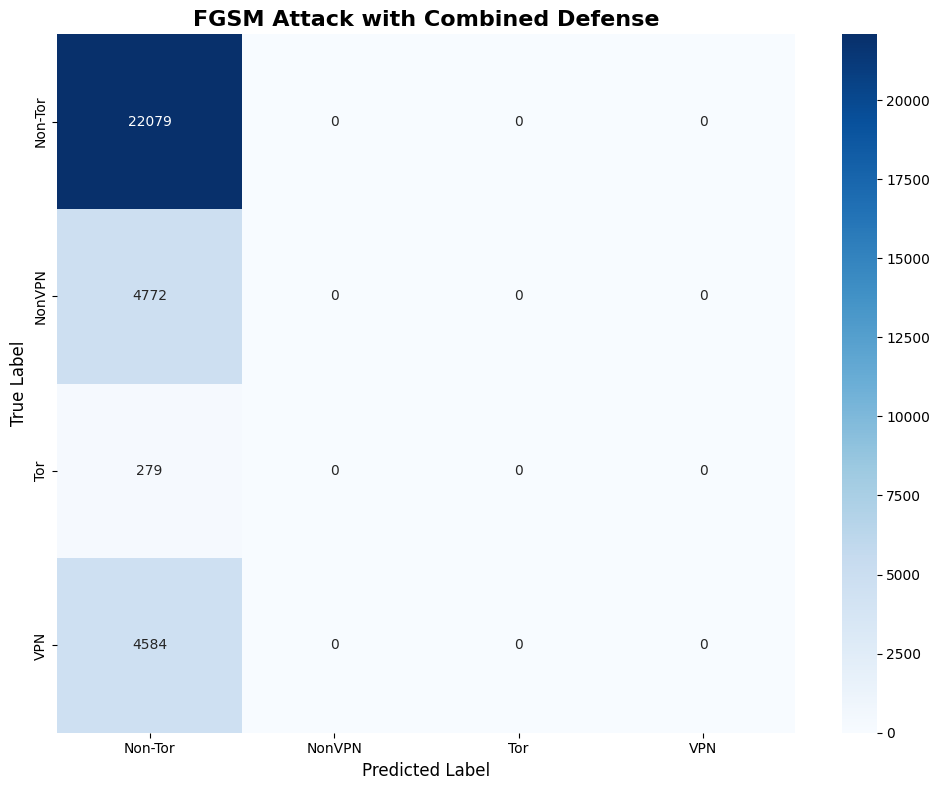


--- Testing: Combined + Median ---

FGSM ATTACK WITH COMBINED + MEDIAN
Accuracy: 69.6191%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.70      1.00      0.82     22079
      NonVPN       0.00      0.00      0.00      4772
         Tor       0.00      0.00      0.00       279
         VPN       0.00      0.00      0.00      4584

    accuracy                           0.70     31714
   macro avg       0.17      0.25      0.21     31714
weighted avg       0.48      0.70      0.57     31714


Confusion Matrix:
[[22079     0     0     0]
 [ 4772     0     0     0]
 [  279     0     0     0]
 [ 4584     0     0     0]]

Defense Time: 124.3901s
Improvement over No Defense: +45.92%


In [ ]:
if 'X_fgsm' in locals() and 'defense' in locals() and data is not None:
    print("\n" + "="*70)
    print("APPLYING COMBINED DEFENSE TO FGSM ATTACK")
    print("="*70)
    
    defense_configs = {
        'Squeezing Only': {
            'squeezing_methods': ['bit_depth', 'quantization'],
            'apply_autoencoder': False,
            'apply_squeezing': True
        },
        'Autoencoder Only': {
            'squeezing_methods': [],
            'apply_autoencoder': True,
            'apply_squeezing': False
        },
        'Combined Defense': {
            'squeezing_methods': ['bit_depth', 'quantization'],
            'apply_autoencoder': True,
            'apply_squeezing': True
        },
        'Combined + Median': {
            'squeezing_methods': ['bit_depth', 'quantization', 'median'],
            'apply_autoencoder': True,
            'apply_squeezing': True
        }
    }
    
    fgsm_results = {'No Defense': fgsm_acc}
    
    for config_name, config in defense_configs.items():
        print(f"\n--- Testing: {config_name} ---")
        
        X_fgsm_2d = X_fgsm.reshape(X_fgsm.shape[0], -1)
        
        start_time = time.time()
        X_fgsm_defended = defense.defend(X_fgsm_2d, **config)
        defense_time = time.time() - start_time
        
        X_fgsm_defended_cnn = X_fgsm_defended.reshape(
            X_fgsm_defended.shape[0], data['n_features'], 1
        ).astype(np.float32)
        
        y_pred_defended_probs = model.predict(X_fgsm_defended_cnn, verbose=0)
        defended_acc, defended_cm = evaluate_model(
            data['y_test_encoded'],
            y_pred_defended_probs,
            f"FGSM Attack with {config_name}",
            data['target_names']
        )
        
        improvement = (defended_acc - fgsm_acc) * 100
        print(f"\nDefense Time: {defense_time:.4f}s")
        print(f"Improvement over No Defense: {improvement:+.2f}%")
        
        fgsm_results[config_name] = defended_acc
        
        if config_name == 'Combined Defense':
            plot_confusion_matrix(
                defended_cm,
                data['target_names'],
                'FGSM Attack with Combined Defense',
                save_path='cm_fgsm_combined_defense.png'
            )
else:
    print("FGSM attack or defense not available. Skipping defense application.")



GENERATING PGD ATTACK (Epsilon = 0.1, Iterations = 40)

Generating adversarial examples...


PGD - Batches: 496it [19:48,  2.60s/it]2025-11-01 19:12:58.310963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



✓ PGD attack generated in 1193.76s

PGD ATTACK (EPS=0.1) - NO DEFENSE
Accuracy: 8.5514%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.08      0.01      0.02     22079
      NonVPN       0.02      0.07      0.03      4772
         Tor       0.40      0.80      0.54       279
         VPN       0.20      0.42      0.27      4584

    accuracy                           0.09     31714
   macro avg       0.18      0.32      0.21     31714
weighted avg       0.09      0.09      0.06     31714


Confusion Matrix:
[[  239 15974    43  5823]
 [ 2437   331   263  1741]
 [    8    31   223    17]
 [  348  2295    22  1919]]

Accuracy Drop: 86.8071%


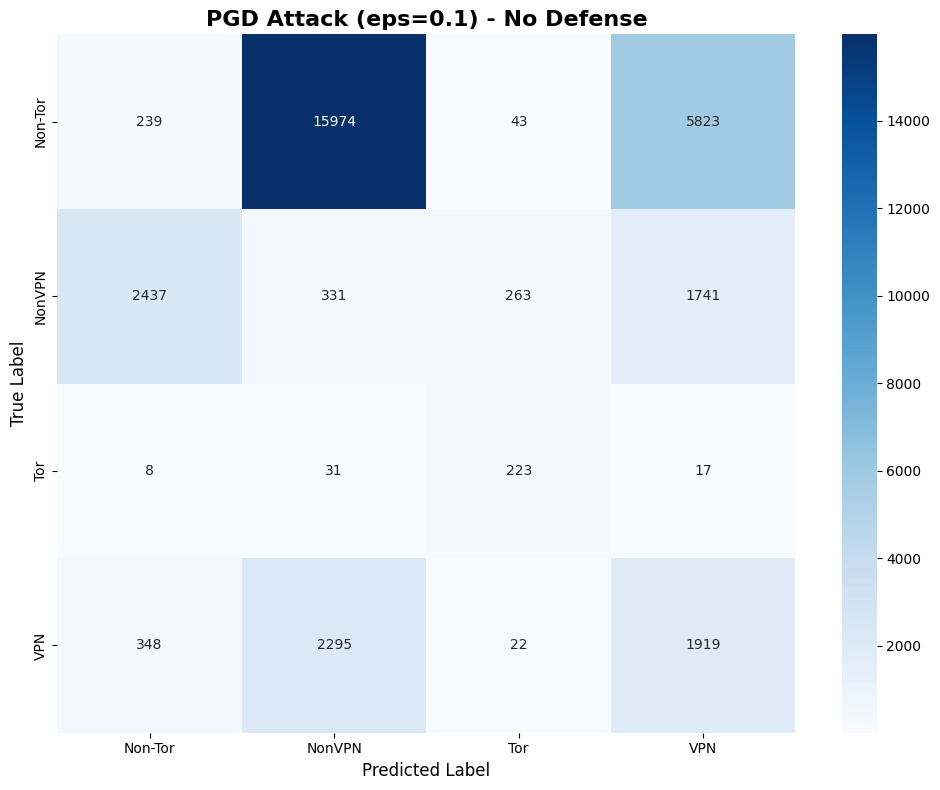

In [ ]:
if 'art_classifier' in locals() and data is not None:
    print("\n" + "="*70)
    print(f"GENERATING PGD ATTACK (Epsilon = {PGD_EPS}, Iterations = {PGD_MAX_ITER})")
    print("="*70)
    
    pgd_attack = ProjectedGradientDescent(
        art_classifier,
        eps=PGD_EPS,
        eps_step=PGD_EPS_STEP,
        max_iter=PGD_MAX_ITER,
        batch_size=ATTACK_BATCH_SIZE,
        verbose=True
    )
    
    print("\nGenerating adversarial examples...")
    start_time = time.time()
    X_pgd = pgd_attack.generate(x=X_test_art, y=data['y_test_ohe'])
    pgd_time = time.time() - start_time
    
    print(f"\n✓ PGD attack generated in {pgd_time:.2f}s")
    
    y_pred_pgd_probs = model.predict(X_pgd, verbose=0)
    pgd_acc, pgd_cm = evaluate_model(
        data['y_test_encoded'],
        y_pred_pgd_probs,
        f"PGD Attack (eps={PGD_EPS}) - No Defense",
        data['target_names']
    )
    
    print(f"\nAccuracy Drop: {(clean_acc - pgd_acc) * 100:.4f}%")
    
    plot_confusion_matrix(
        pgd_cm,
        data['target_names'],
        f'PGD Attack (eps={PGD_EPS}) - No Defense',
        save_path='cm_pgd_no_defense.png'
    )
else:
    print("ART classifier or data not loaded. Skipping PGD attack.")


APPLYING COMBINED DEFENSE TO PGD ATTACK

--- Testing: Squeezing Only ---

PGD ATTACK WITH SQUEEZING ONLY
Accuracy: 69.6191%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.70      1.00      0.82     22079
      NonVPN       0.00      0.00      0.00      4772
         Tor       0.00      0.00      0.00       279
         VPN       0.00      0.00      0.00      4584

    accuracy                           0.70     31714
   macro avg       0.17      0.25      0.21     31714
weighted avg       0.48      0.70      0.57     31714


Confusion Matrix:
[[22079     0     0     0]
 [ 4772     0     0     0]
 [  279     0     0     0]
 [ 4584     0     0     0]]

Defense Time: 0.0864s
Improvement over No Defense: +61.07%

--- Testing: Autoencoder Only ---

PGD ATTACK WITH AUTOENCODER ONLY
Accuracy: 69.5907%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.70      1.00      0.82     22079
      N

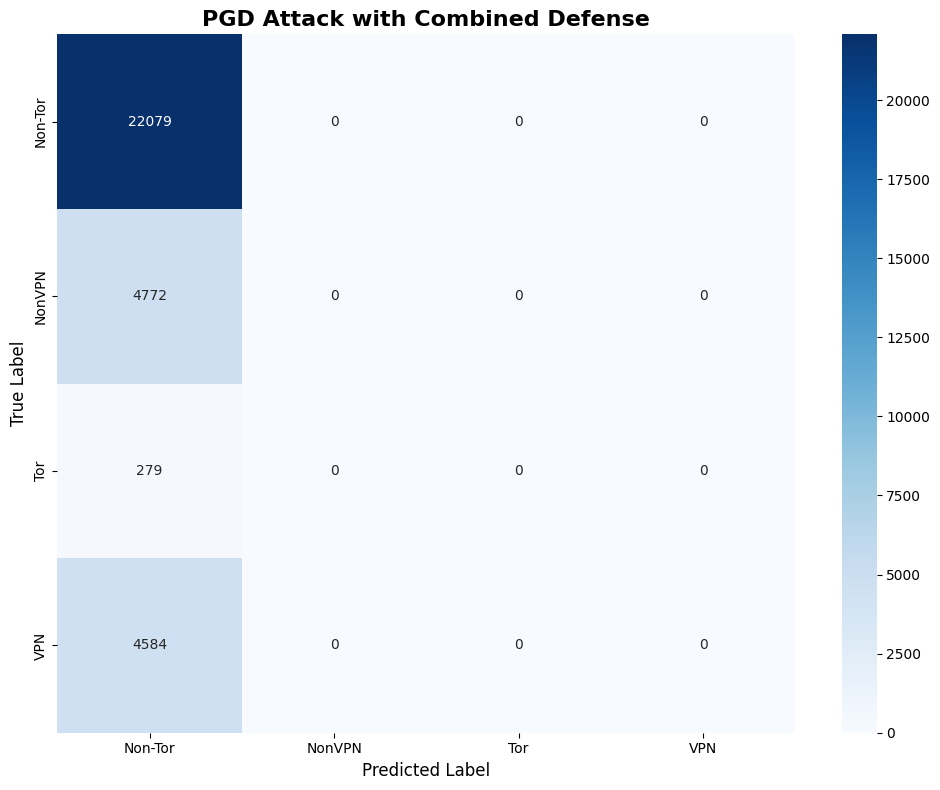


--- Testing: Combined + Median ---

PGD ATTACK WITH COMBINED + MEDIAN
Accuracy: 69.6191%

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.70      1.00      0.82     22079
      NonVPN       0.00      0.00      0.00      4772
         Tor       0.00      0.00      0.00       279
         VPN       0.00      0.00      0.00      4584

    accuracy                           0.70     31714
   macro avg       0.17      0.25      0.21     31714
weighted avg       0.48      0.70      0.57     31714


Confusion Matrix:
[[22079     0     0     0]
 [ 4772     0     0     0]
 [  279     0     0     0]
 [ 4584     0     0     0]]

Defense Time: 126.1206s
Improvement over No Defense: +61.07%


In [ ]:
if 'X_pgd' in locals() and 'defense' in locals() and data is not None:
    print("\n" + "="*70)
    print("APPLYING COMBINED DEFENSE TO PGD ATTACK")
    print("="*70)
    
    pgd_results = {'No Defense': pgd_acc}
    
    for config_name, config in defense_configs.items():
        print(f"\n--- Testing: {config_name} ---")
        
        X_pgd_2d = X_pgd.reshape(X_pgd.shape[0], -1)
        
        start_time = time.time()
        X_pgd_defended = defense.defend(X_pgd_2d, **config)
        defense_time = time.time() - start_time
        
        X_pgd_defended_cnn = X_pgd_defended.reshape(
            X_pgd_defended.shape[0], data['n_features'], 1
        ).astype(np.float32)
        
        y_pred_defended_probs = model.predict(X_pgd_defended_cnn, verbose=0)
        defended_acc, defended_cm = evaluate_model(
            data['y_test_encoded'],
            y_pred_defended_probs,
            f"PGD Attack with {config_name}",
            data['target_names']
        )
        
        improvement = (defended_acc - pgd_acc) * 100
        print(f"\nDefense Time: {defense_time:.4f}s")
        print(f"Improvement over No Defense: {improvement:+.2f}%")
        
        pgd_results[config_name] = defended_acc
        
        if config_name == 'Combined Defense':
            plot_confusion_matrix(
                defended_cm,
                data['target_names'],
                'PGD Attack with Combined Defense',
                save_path='cm_pgd_combined_defense.png'
            )
else:
    print("PGD attack or defense not available. Skipping defense application.")



COMPARATIVE ANALYSIS

Results Summary:
Attack Type            Clean   FGSM    PGD
Defense Configuration                     
Autoencoder Only         NaN  69.60  69.59
Baseline               95.36    NaN    NaN
Combined + Median        NaN  69.62  69.62
Combined Defense         NaN  69.62  69.62
No Defense               NaN  23.70   8.55
Squeezing Only           NaN  69.62  69.62


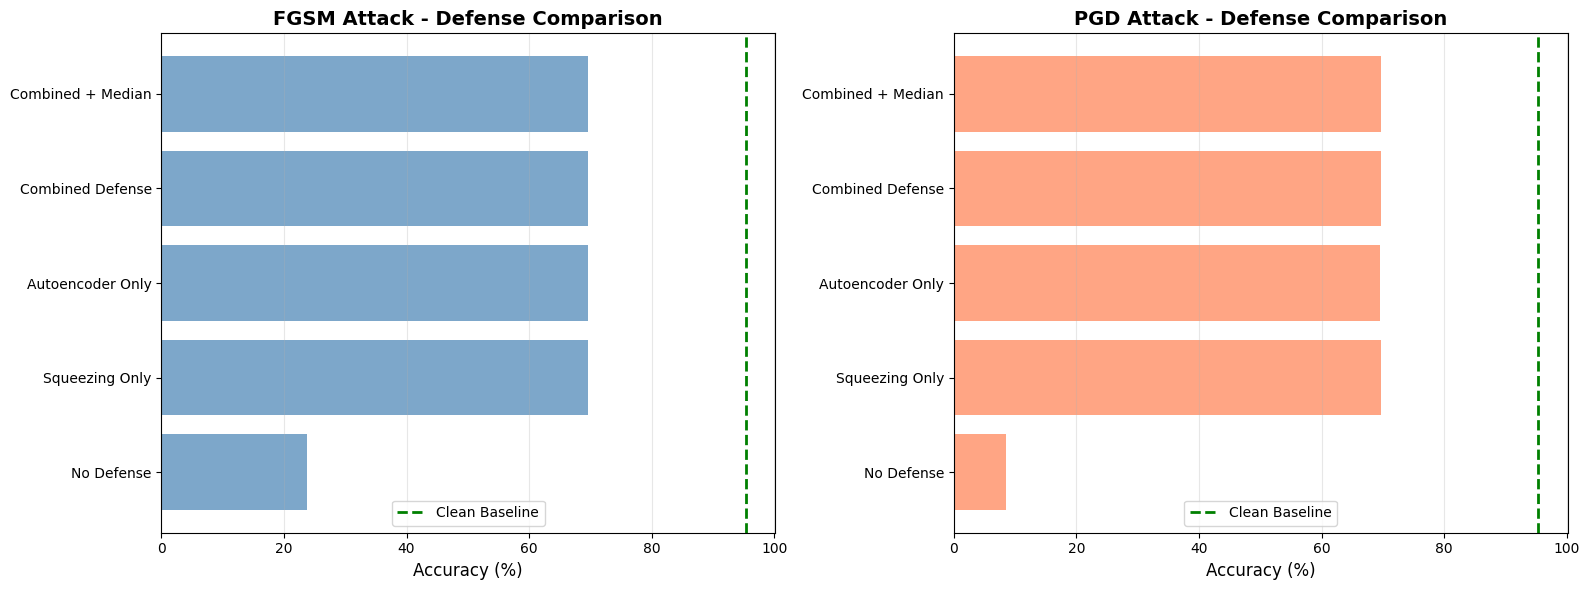

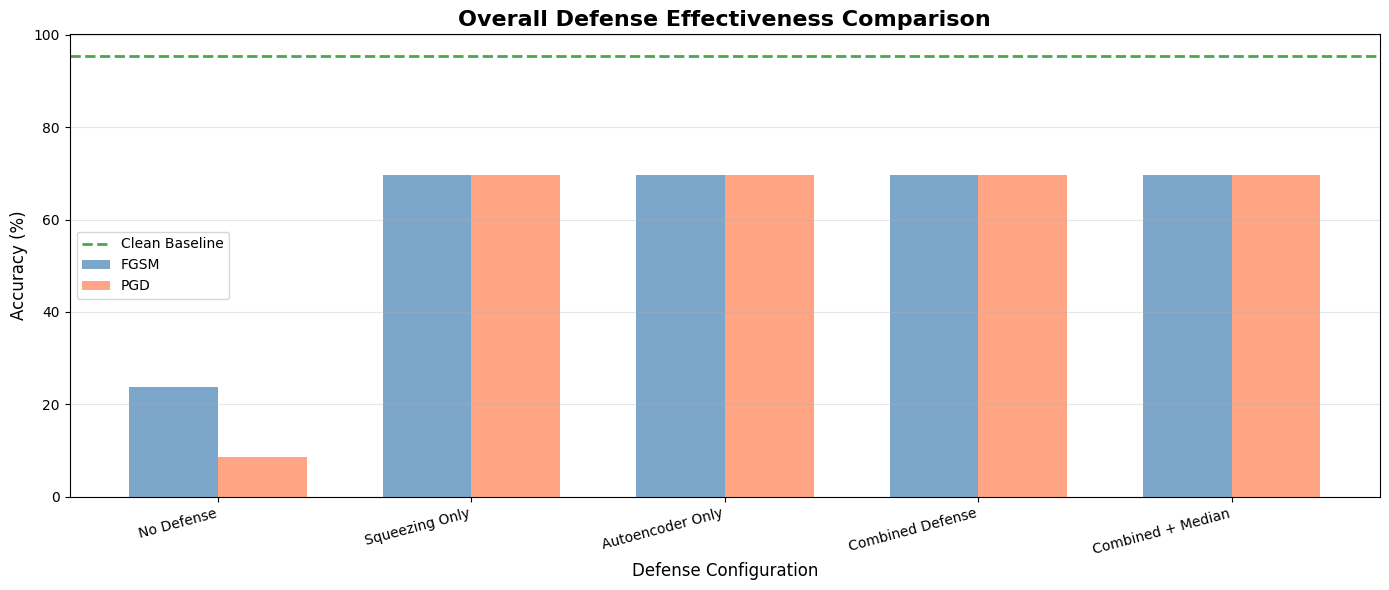

In [17]:
if 'fgsm_results' in locals() and 'pgd_results' in locals():
    print("\n" + "="*70)
    print("COMPARATIVE ANALYSIS")
    print("="*70)
    
    # Create comparison dataframe
    comparison_data = []
    
    for config in fgsm_results.keys():
        comparison_data.append({
            'Defense Configuration': config,
            'Attack Type': 'FGSM',
            'Accuracy': fgsm_results[config] * 100
        })
    
    for config in pgd_results.keys():
        comparison_data.append({
            'Defense Configuration': config,
            'Attack Type': 'PGD',
            'Accuracy': pgd_results[config] * 100
        })
    
    # Add baseline
    comparison_data.append({
        'Defense Configuration': 'Baseline',
        'Attack Type': 'Clean',
        'Accuracy': clean_acc * 100
    })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Print comparison table
    print("\nResults Summary:")
    print(df_comparison.pivot(index='Defense Configuration', 
                              columns='Attack Type', 
                              values='Accuracy').round(2))
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # FGSM comparison
    configs = list(fgsm_results.keys())
    fgsm_accs = [fgsm_results[c] * 100 for c in configs]
    
    axes[0].barh(configs, fgsm_accs, color='steelblue', alpha=0.7)
    axes[0].axvline(clean_acc * 100, color='green', linestyle='--', 
                   linewidth=2, label='Clean Baseline')
    axes[0].set_xlabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('FGSM Attack - Defense Comparison', 
                     fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    
    # PGD comparison
    pgd_accs = [pgd_results[c] * 100 for c in configs]
    
    axes[1].barh(configs, pgd_accs, color='coral', alpha=0.7)
    axes[1].axvline(clean_acc * 100, color='green', linestyle='--',
                   linewidth=2, label='Clean Baseline')
    axes[1].set_xlabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('PGD Attack - Defense Comparison',
                     fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('defense_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Overall comparison plot
    plt.figure(figsize=(14, 6))
    
    df_plot = df_comparison[df_comparison['Defense Configuration'] != 'Baseline']
    
    x = np.arange(len(configs))
    width = 0.35
    
    fgsm_vals = [fgsm_results[c] * 100 for c in configs]
    pgd_vals = [pgd_results[c] * 100 for c in configs]
    
    plt.bar(x - width/2, fgsm_vals, width, label='FGSM', 
           color='steelblue', alpha=0.7)
    plt.bar(x + width/2, pgd_vals, width, label='PGD',
           color='coral', alpha=0.7)
    
    plt.axhline(clean_acc * 100, color='green', linestyle='--',
               linewidth=2, label='Clean Baseline', alpha=0.7)
    
    plt.xlabel('Defense Configuration', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Overall Defense Effectiveness Comparison',
             fontsize=16, fontweight='bold')
    plt.xticks(x, configs, rotation=15, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('overall_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


In [19]:
if 'fgsm_results' in locals() and 'pgd_results' in locals():
    print("\n" + "="*70)
    print("FINAL SUMMARY REPORT")
    print("="*70)
    
    report = f"""
ADVERSARIAL DEFENSE EVALUATION REPORT
CIC-Darknet2020 Dataset
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*70}
1. BASELINE PERFORMANCE (Clean Data)
{'='*70}
Accuracy: {clean_acc * 100:.4f}%

{'='*70}
2. FGSM ATTACK RESULTS (Epsilon = {FGSM_EPS})
{'='*70}
"""
    
    for config, acc in fgsm_results.items():
        improvement = (acc - fgsm_results['No Defense']) * 100
        report += f"\n{config:25s}: {acc * 100:6.2f}% "
        if config != 'No Defense':
            report += f"(+{improvement:5.2f}%)"
    
    report += f"""

Best FGSM Defense: {max(fgsm_results, key=fgsm_results.get)}
Best FGSM Accuracy: {max(fgsm_results.values()) * 100:.2f}%

{'='*70}
3. PGD ATTACK RESULTS (Epsilon = {PGD_EPS}, Iterations = {PGD_MAX_ITER})
{'='*70}
"""
    
    for config, acc in pgd_results.items():
        improvement = (acc - pgd_results['No Defense']) * 100
        report += f"\n{config:25s}: {acc * 100:6.2f}% "
        if config != 'No Defense':
            report += f"(+{improvement:5.2f}%)"
    
    report += f"""

Best PGD Defense: {max(pgd_results, key=pgd_results.get)}
Best PGD Accuracy: {max(pgd_results.values()) * 100:.2f}%

{'='*70}
4. KEY FINDINGS
{'='*70}

Combined Defense System Performance:
  - FGSM Attack: {fgsm_results['Combined Defense'] * 100:.2f}% accuracy
  - PGD Attack: {pgd_results['Combined Defense'] * 100:.2f}% accuracy
  - Average Improvement: {((fgsm_results['Combined Defense'] - fgsm_results['No Defense']) + (pgd_results['Combined Defense'] - pgd_results['No Defense'])) / 2 * 100:.2f}%

Defense Components Analysis:
  - Squeezing Only (FGSM): {(fgsm_results['Squeezing Only'] - fgsm_results['No Defense']) * 100:.2f}% improvement
  - Autoencoder Only (FGSM): {(fgsm_results['Autoencoder Only'] - fgsm_results['No Defense']) * 100:.2f}% improvement
  - Combined (FGSM): {(fgsm_results['Combined Defense'] - fgsm_results['No Defense']) * 100:.2f}% improvement

{'='*70}
END OF REPORT
{'='*70}
    """
    
    print(report)
    
    # Save report to file
    with open('defense_evaluation_report.txt', 'w') as f:
        f.write(report)
    
    print("\n✓ Report saved to 'defense_evaluation_report.txt'")


FINAL SUMMARY REPORT

ADVERSARIAL DEFENSE EVALUATION REPORT
CIC-Darknet2020 Dataset
Generated: 2025-11-01 19:18:10

1. BASELINE PERFORMANCE (Clean Data)
Accuracy: 95.3585%

2. FGSM ATTACK RESULTS (Epsilon = 0.1)

No Defense               :  23.70% 
Squeezing Only           :  69.62% (+45.92%)
Autoencoder Only         :  69.60% (+45.90%)
Combined Defense         :  69.62% (+45.92%)
Combined + Median        :  69.62% (+45.92%)

Best FGSM Defense: Squeezing Only
Best FGSM Accuracy: 69.62%

3. PGD ATTACK RESULTS (Epsilon = 0.1, Iterations = 40)

No Defense               :   8.55% 
Squeezing Only           :  69.62% (+61.07%)
Autoencoder Only         :  69.59% (+61.04%)
Combined Defense         :  69.62% (+61.07%)
Combined + Median        :  69.62% (+61.07%)

Best PGD Defense: Squeezing Only
Best PGD Accuracy: 69.62%

4. KEY FINDINGS

Combined Defense System Performance:
  - FGSM Attack: 69.62% accuracy
  - PGD Attack: 69.62% accuracy
  - Average Improvement: 53.49%

Defense Components Ana